# 0. Importamos las librerías que vamos a necesitar

In [41]:
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import re

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Sequence, defaultdict

# 1. Análisis exploratorio de reviews de Amazon.

 ## Cargamos los datos
 
 Para el topic modeling, usaremos 8.000 reviews obtenidas de los siguientes datasets:
 
 - Bebe.
 - Suministros para mascotas.
 - Salud y cuidado personal.
 - Videojuegos.
 
Estos datos están extraidos de [Reviews de Amazon](http://jmcauley.ucsd.edu/data/amazon/)
 
Se seleccionarán 2.000 de cada, con lo que trabajaremos con un dataset de 8.000 para esta parte de la práctica.

In [2]:
import json

#cargamos el dataset de Videogames
dfVideogames = pd.read_json('data/Videogames.json', lines = True)
#cargamos el dataset de Babies
dfBaby = pd.read_json('data/Baby.json', lines = True)
#cargamos el dataset de Health and Personal Care
dfHealth = pd.read_json('data/Health.json', lines = True) 
#cargamos el dataset de Pets Supplies
dfPets = pd.read_json('data/Pets.json', lines = True)

### Comprobamos que se hayan cargado bien:

Dataset de videojuegos:

In [3]:
print(dfVideogames.shape)
dfVideogames.head()

(231780, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,"06 14, 2011"


Dataset de bebes:

In [4]:
print(dfBaby.shape)
dfBaby.head()

(160792, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4,Great,1396310400,"04 1, 2014"


Dataset de suministros de mascotas:

In [5]:
print(dfPets.shape)
dfPets.head()

(157836, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2,1330905600,"03 5, 2012"


Dataset de salud y cuidado personal:

In [6]:
print(dfHealth.shape)
dfHealth.head()

(346355, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5,Very nice and convenient.,1313452800,"08 16, 2011"


Como sólo estamos interesados en saber de que se está hablando, la única variable que nos insteresa es reviewText, las otras las eliminaresmos así como los NA's, para todos los datasets.

In [7]:
dfVideogames = dfVideogames[['reviewText']]
dfVideogames.dropna(inplace = True)
print(dfVideogames.shape)
dfBaby = dfBaby[['reviewText']]
dfBaby.dropna(inplace = True)
print(dfBaby.shape)
dfPets = dfPets[['reviewText']]
dfPets.dropna(inplace = True)
print(dfPets.shape)
dfHealth = dfHealth[['reviewText']]
dfHealth.dropna(inplace = True)
print(dfHealth.shape)

(231780, 1)
(160792, 1)
(157836, 1)
(346355, 1)


Ahora que ya tenemos los datos que queremos, vamos a crear nuestro dataset, que como ya se ha comentado antes, será el resultado de concatenar 5.000 reviews de cada uno de los datasets anteriores.

In [8]:
df = pd.concat([dfVideogames[:2000], dfBaby[:2000], dfHealth[:2000], dfPets[:2000]], axis=0, ignore_index = True)

In [9]:
print(df.shape)
df['reviewText'][0]

(8000, 1)


'Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don\'t like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I\'m really tired of arcade style rally/racing games anyway.I\'ll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.'

# 2. Preprocesamiento

Realizaremos los siguientes:

- Tokenización: dividir el texto en oraciones y las oraciones en palabras.
- Poner en minúsculas las palabras y eliminar la puntuación.
- Se eliminan las palabras que tienen menos de 2 caracteres.
- Todas las palabras vacías se eliminan.
- Lematización: las palabras en 3ª persona se cambian a 1ª, y los verbos en tiempo pasado y futuro se cambian a presente.
- Eliminaremos las url.

Para ello, utilizamos gensim para eliminar los stopwords, y las palabras con un len inferior a 3. Así que en esta primera iteración empezaremos con esta opción.

Usaremos lemmatizer para pasar eliminar las mayúsculas, los plurales y los signos de puntuación. Y stemmer para poner los verbos en presente y pasar de 3ª persona a 1ª.

Para eliminar las url, usaremos la expresión regular (re).

In [10]:
stemmer = SnowballStemmer("english")
def deleteUrl(text):
    text = re.sub(r"http\S+", "", text)
    return text

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    text = deleteUrl(text)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [11]:
print('Original text:\n{}\n\n'.format(df['reviewText'][0]))
print('Processed text:\n{}'.format(preprocess(df['reviewText'][0])))

Original text:
Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.


Processed text:
['instal', 'game', 'struggl', 'game', 'window', 'live', 'bug', 'championship', 'race', 'car', 'unlock', 'buy', 'addon', 'game', 'pay', 'near', 'dollar', 'game', 'like', 'idea', 'pay', 'pl

Como podemos observar, el preprocesado funcionas bastante bien, así que vamos a aplicarlo a nuestro dataset.

In [12]:
processed_texts = []
for text in df['reviewText']:
    processed_texts.append(preprocess(text))

Estos son nuestros textos procesados. Como podemos ver, en algunos verbos, no acaba de funcionar todo lo bien que nos gustaría, como es el caso de 'happi' o 'featur' o 'choos', por decir algunas. Aunque para topic modeling, no creo que sean muy graves estos fallos en el preprocesado, aún así, si los resultados no son concluyentes, podemos crear un preprocesado más sencillo, para ver que resultados obtenemos.

In [13]:
print(processed_texts[10])

['finish', 'game', 'dirt', 'tour', 'mode', 'believ', 'experi', 'bulk', 'game', 'offer', 'happi', 'game', 'awesom', 'great', 'car', 'great', 'track', 'race', 'mode', 'excel', 'gameplay', 'graphic', 'highlight', 'race', 'snow', 'track', 'aspen', 'cool', 'obstacl', 'cours', 'pavement', 'seri', 'felt', 'game', 'plagu', 'difficulti', 'spike', 'dirt', 'race', 'tri', 'casual', 'difficulti', 'lose', 'time', 'medium', 'custom', 'difficulti', 'set', 'choos', 'level', 'challeng', 'pick', 'choos', 'assist', 'handl', 'option', 'basic', 'game', 'play', 'hold', 'throttl', 'steer', 'gradual', 'step', 'reach', 'feel', 'work', 'best', 'love', 'featur', 'sad', 'option', 'increas', 'control', 'dead', 'zone', 'adjust', 'sensit', 'tweak', 'ideal', 'like', 'previous', 'game', 'handl', 'flighti', 'speed', 'loos', 'grind', 'feel', 'thing', 'tighten', 'somewhat', 'dirt', 'cigar', 'step', 'forward', 'game', 'run', 'smooth', 'silk', 'set', 'max', 'issu', 'whatsoev', 'enjoy', 'race', 'game', 'ignor', 'best', 'dirt

## Creamos nuestro diccionario y nuestro corpus 

### Diccionario id - palabra

Ahora que va tenemos nuestros tokens, vamos a crearnos nuestro diccionario clave - valor con el módulo Dictionary de la librería de gensim.corpora.


In [14]:
dictionary = Dictionary(processed_texts)

In [15]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [16]:
list(dictionary.items())

[(0, 'addon'),
 (1, 'arcad'),
 (2, 'bug'),
 (3, 'burn'),
 (4, 'buy'),
 (5, 'car'),
 (6, 'championship'),
 (7, 'codemast'),
 (8, 'compar'),
 (9, 'continu'),
 (10, 'dirt'),
 (11, 'dollar'),
 (12, 'enjoy'),
 (13, 'game'),
 (14, 'garbag'),
 (15, 'graphic'),
 (16, 'help'),
 (17, 'idea'),
 (18, 'improv'),
 (19, 'instal'),
 (20, 'like'),
 (21, 'live'),
 (22, 'near'),
 (23, 'notic'),
 (24, 'pay'),
 (25, 'physic'),
 (26, 'play'),
 (27, 'race'),
 (28, 'ralli'),
 (29, 'rate'),
 (30, 'read'),
 (31, 'review'),
 (32, 'richard'),
 (33, 'struggl'),
 (34, 'style'),
 (35, 'sure'),
 (36, 'tire'),
 (37, 'toss'),
 (38, 'unlock'),
 (39, 'vow'),
 (40, 'window'),
 (41, 'accent'),
 (42, 'america'),
 (43, 'best'),
 (44, 'english'),
 (45, 'european'),
 (46, 'huge'),
 (47, 'market'),
 (48, 'multiplay'),
 (49, 'music'),
 (50, 'orient'),
 (51, 'parti'),
 (52, 'voic'),
 (53, 'work'),
 (54, 'arriv'),
 (55, 'book'),
 (56, 'contact'),
 (57, 'content'),
 (58, 'fake'),
 (59, 'good'),
 (60, 'insid'),
 (61, 'instead'),
 (6

In [17]:
len(dictionary)

13653

### Corpus

En el espacio vectorial, cualquier corpus puede representarse como una matriz de término de documento. La siguiente matríz muestra nuestro corpus de N documentos y el tamaño de nuestro diccionacio. el valor de la celda i, j da el recuento de frecuencia de la palabra en el documento.

In [18]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [19]:
len(corpus)

8000

In [20]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 6),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 2),
 (25, 1),
 (26, 1),
 (27, 2),
 (28, 2),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1)]

## Entrenamos el modelo (LDA)

LDA es la técnica de modelado de temas más popular, que supone que los documentos se producen a partir de una mezcla de temas.Esos temas generan palabras basadas en su distribución de probabilidad.
Dado un conjunto de datos de documentos, LDA retrocede e intenta averiguar qué temas crearían esos documentos en primer lugar

Parametros que le pasamos a nuestro modelo:
num_topics: número de temas que se extraerán del corpus, ya que nuestro dataset esta compuesto por 4 diferentes (baby, pets, videogames y health) lo que esperamos es que sean 4

In [21]:
num_topics = 4 #número de topics

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [22]:
lda_model.show_topics()

[(0,
  '0.016*"product" + 0.015*"work" + 0.011*"food" + 0.009*"clean" + 0.009*"cat" + 0.009*"time" + 0.009*"like" + 0.008*"year" + 0.008*"litter" + 0.008*"water"'),
 (1,
  '0.017*"love" + 0.016*"great" + 0.015*"bottl" + 0.013*"clean" + 0.012*"easi" + 0.012*"like" + 0.011*"babi" + 0.011*"work" + 0.010*"littl" + 0.010*"potti"'),
 (2,
  '0.071*"game" + 0.018*"play" + 0.011*"time" + 0.011*"like" + 0.009*"level" + 0.008*"graphic" + 0.007*"charact" + 0.006*"good" + 0.006*"best" + 0.006*"great"'),
 (3,
  '0.021*"batteri" + 0.016*"chew" + 0.016*"like" + 0.013*"ball" + 0.012*"good" + 0.012*"love" + 0.011*"time" + 0.010*"dog" + 0.010*"play" + 0.008*"toy"')]

Vamos a observar el top 20 de palabras por cada topic.

In [23]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04
0,product,love,game,batteri
1,work,great,play,chew
2,food,bottl,time,like
3,clean,clean,like,ball
4,cat,easi,level,good
5,time,like,graphic,love
6,like,babi,charact,time
7,year,work,good,dog
8,litter,littl,best,play
9,water,potti,great,toy


Según este resultado, podemos diferenciar cláramente los 4 tópics:
- el topic#01 hace referencia a productos para animales.
- el topic#02 hace referencia a productos para bebes.
- el topic#03 hace referencia a productos de cuidados personales.
- el topic#04 hace referencia a videojuegos.

## Perplexity y coherence

In [24]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.345129028805744

Coherence Score:  0.4014171681891972


In [25]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

C:\Users\Georgina\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.229794  0.024600       1        1  38.512688
1      0.113974 -0.073276       2        1  22.918533
0      0.105945  0.140769       3        1  21.893473
3      0.009875 -0.092092       4        1  16.675304, topic_info=     Category         Freq       Term        Total  loglift  logprob
13    Default  8833.000000       game  8833.000000  30.0000  30.0000
1348  Default  1154.000000    batteri  1154.000000  29.0000  29.0000
9057  Default   908.000000       chew   908.000000  28.0000  28.0000
3814  Default  1170.000000      bottl  1170.000000  27.0000  27.0000
26    Default  2938.000000       play  2938.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
688    Topic4   249.676697  recommend  1046.579346   0.3581  -5.3750
111    Topic4   291.962677      great  2579.938477  -0.3877  -5.2185
1238   Topic4   247.749130      month  1164.685791   0.2435  -5.3827
210    Topic4   240.853058       year  1397.010986   0.0333  -5.4109
4      Topic4   239.093140        buy  1332.353638   0.0734  -5.4183

[299 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
707        1  0.994485  adventur
3297       3  0.017877   aggress
3297       4  0.965360   aggress
10759      3  0.011084   alkalin
10759      4  0.986476   alkalin
...      ...       ...       ...
210        1  0.173943      year
210        2  0.230492      year
210        3  0.423046      year
210        4  0.172511      year
706        1  0.999289     zelda

[585 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

Si obervamos la gráfica, nos muestra las palabras más representativas para cada topic. Si bien en el apartado anterior podía ser un poco complicado el topic 3, aquí quedaría más claro,(en la gráfica equivale al número 4).
El resto de topics siguen estando muy bien diferenciados y definidos por las palabras que lo representan.

In [26]:
pyLDAvis.save_html(vis, './results/topics_vis_k=4.html')

### Número óptimo de topics

Aúnque sabemos que tenemos 4 tópics, por que así lo hemos definido al utilizar 4 dataset, en un problema real no sabríamos de cuantos temas se están hablando, para ello tenemos vamos a optimizar el número de topics.

Para ello, construiremos varios modelos LDA con diferente número de topics, y nos quedaremos con aquesl que devuelva el valor de coherence mas grande.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Si partimos de la premisa que no sabemos cuantos tópicos hay, lo lógico sería empezar para k = 1 y llegar hasta un número más o menos grande, así empezaremos a partir de k=1 con un máximo de k=25, y evaluaremos cada uno de ellos range[4:24] Depende del resultado, deberíamos evaluarlo para k mayor de 25.

In [28]:
start_ = 1
end_ = 25
step_ = 1

In [29]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

In [30]:
print(coherence_values)

[0.27528893985007524, 0.27185375338718826, 0.3103809899058997, 0.29780334953526877, 0.31470830495302077, 0.28292639283696003, 0.31601634182786426, 0.2698591811049387, 0.279162341713986, 0.2952481681368109, 0.27695711350150715, 0.29990261715017386, 0.30107516965650755, 0.28306068737730017, 0.28712943868693813, 0.30643266053930146, 0.2936772851751753, 0.3037988352338479, 0.28834014461830815, 0.2841135550613682, 0.2883730939085029, 0.2919810849634582, 0.3019273294301133, 0.29481063036804867]


In [31]:
print(coherence_values[4])

0.31470830495302077


In [32]:
print(coherence_values[9])

0.2952481681368109


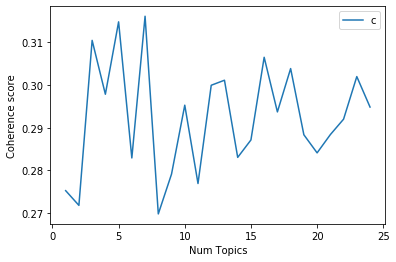

In [33]:
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Según optimizador, el número optimo de topics es 10 con un valor de coherencia de 0.3171090539549324



## Reevaluamos para número óptimo de tópics

Vamos a evaluar el modelo para n_topics = 10 y vemos que ocurre.

In [34]:
num_topics = 10 #número óptimo de topics

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [35]:
optimal_model_id =10

In [36]:
optimal_model = model_list[optimal_model_id]

word_dict = {};
for i in range(10):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,puppi,sheet,smell,work,clean,game,like,litter,game,game
1,ball,product,like,product,seat,like,clean,dog,play,like
2,bone,game,clean,food,great,shower,work,love,great,good
3,love,time,pump,like,daughter,play,brush,month,good,love
4,game,month,game,price,toilet,time,water,time,like,time
5,good,great,love,time,easi,good,bottl,littl,digest,great
6,littl,work,dog,toy,bottl,great,great,like,need,play
7,daughter,babi,work,good,time,think,time,great,cord,thing
8,product,snap,refil,love,like,go,good,batteri,best,littl
9,like,littl,time,great,littl,cup,year,chair,know,flavor


In [37]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.576839991509499

Coherence Score:  0.4018145378925535


In [38]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

C:\Users\Georgina\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.239033 -0.017317       1        1  16.503502
6      0.241863 -0.006296       2        1  15.203866
7     -0.101462  0.059321       3        1  12.302111
2     -0.106163 -0.110125       4        1  11.860274
3      0.163882  0.009753       5        1   9.897532
1     -0.104498 -0.043315       6        1   8.227221
4     -0.068676 -0.182799       7        1   7.907411
0     -0.113063  0.008210       8        1   6.799537
9     -0.091400  0.029583       9        1   6.308185
8     -0.059516  0.252986      10        1   4.990374, topic_info=     Category         Freq     Term        Total  loglift  logprob
13    Default  8281.000000     game  8281.000000  30.0000  30.0000
26    Default  3026.000000     play  3026.000000  29.0000  29.0000
1007  Default  1651.000000    clean  1651.000000  28.0000  28.0000
1348  Default  1184.000000  batteri  1184.000000  27.0000  27.0000
970   Default  1700.000000  product  1700.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
4219  Topic10    79.061424    drink   207.308228   2.0337  -5.3185
190   Topic10    97.164673    thing  1418.394409   0.3168  -5.1123
128   Topic10    88.072357     long   935.341797   0.6349  -5.2106
150   Topic10    81.451439   pretti   706.568726   0.8372  -5.2887
684   Topic10    81.505730      get  1130.893799   0.3676  -5.2880

[706 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1928      1  0.042401     act
1928      2  0.943420     act
1928      5  0.010600     act
9486      4  0.979578   adhes
297       3  0.037927  adjust
...     ...       ...     ...
4583      1  0.975116   yoshi
706       1  0.977271   zelda
706       2  0.014514   zelda
706       5  0.007257   zelda
3448      2  0.991214   zombi

[1836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 3, 4, 2, 5, 1, 10, 9])

In [39]:
pyLDAvis.save_html(vis, './results/topics_vis_k=10.html')

# Conclusiones


Hemos evaluado con 4 dataset extraidos de las reviews de Amazon con un modelo LDA, para encontrar de que se está hablando. Resulta curioso como, teniendo en cuenta que los dataset escogidos están muy diferenciados, ya que uno habla de videojuegos, otro de salut, otro de animales de compañia y otro de bebés, estos 3 últimos están tan cerca unos de los otros.(como se puede observar para las 2 visualizaciones).

Supongo que eso se debe a que estos últimos hablan de productos y el de viedojuegos hace referencia a juegos.

Quizás también deberíamos eliminar de nuestro diccionario palabras como love, problem, recommend, que son más propios de análisis de sentimiento y en este caso, lo único que hace, es añadirnos ruido a nuestro modelo.

También hay que tener en cuenta, las granja de edad que conforman los grupos de consumidores no son los mismos para videojuegos que para el resto de 
productos.

### Tabla con los resultados de los dos entrenamientos:



***


|    NUMERO TOPICS   |       PERPLEXITY     |       COHERENCE     |
|--------------------|:--------------------:|--------------------:|
|          4         |  -7.345129028805744  |  0.4014171681891972 |
|         10         |  -7.576839991509499  |  0.4018145378925535 |


***

Como podemos observar en la tabla, el modelo funciona bastante bien para 4 tópics, ya que, aunque al optimizar los parámetros de número de topics, nos salga que es 10, y es cierto que la diferencia entre ambos es muy baja, y puesto a elegir queda más claro con 4 topics.

    